# Training attempt 1: Thomson Lam 

## Summary: 

I am using 2014–2017 for Training/CV and 2018–2019 as my Final Test Set to prove the model's accuracy against known 2023/2024 rents. Once validated, I will use the 2020–2024 data to generate the actual 5-year forecasts for the city.

## Issues:
crime rate has low relevancy - currently just noise for XGB to overfit on: verify that crime rate data is relevant and joined correctly
missing 2016-2018 bedroom stats
missing 2022-2023 bedrooms stats

Strategy
do correlation matrix & ablation studies (SHAP), figure out what the model is overfitting on, or whether the data is just noisy.

```
1) inidividual yearly pipelines -> 2) pipelines to combine the yearly datasets into mastersheet
```
All individual pipelines require review & verification that the data is done correctly: 

```
1) is the whole year of data being used? 2) are the joins (data being joined together) correctly sourced (ie. crime data is not the same from 2024)?
```

Iterative: 
review data pipeline and diagnose the issue - 1) missing data, 2) data quality
review crime data & ensure quality of crime data
train grid search again

Considerations: 
if crime data is still bad, drop crime data
review missing data and data pipeline, and include them back into it
consider changing the target variable from 5 year lookup to just the next year
check training strategy and columns, ensure there is no data leakage across time; there should not be because the time split was done correctly
review master sheet variables and check whether the master sheet pipeline built the dataset correctly
review grid search: is regularization being applied correctly? Elasticnet or Lasso?

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score 
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
train_df.head()

Train shape: (790, 27)
Test shape: (316, 27)


,AREA_NAME,1_bedrooms_leased,2_bedrooms_avg_lease_rate,area_sq_meters,perimeter_meters,park_count,ASSAULT_RATE,AUTOTHEFT_RATE,ROBBERY_RATE,THEFTOVER_RATE,...,YEAR,avg_rent_1br,rent_lag_1,rent_lag_2,rent_growth_rate,TARGET_RENT_5YR,is_missing_THEFTOVER_RATE,is_missing_ROBBERY_RATE,is_missing_AUTOTHEFT_RATE,years_since_baseline
0,Agincourt North,135.0,1518.5,0.000813,0.134458,10.0,221.209717,56.127838,118.858955,3.301638,...,2014,1301.500000,1318.250000,1272.750000,-1.270624,1868.265625,0,0,0,0
1,Agincourt North,110.0,1547.5,0.000813,0.134458,10.0,257.275543,96.895988,123.625916,20.047445,...,2015,1342.250000,1301.500000,1318.250000,3.131003,1821.479821,0,0,0,1
2,Agincourt North,25.0,1749.0,0.000813,0.134458,10.0,274.091644,60.166462,50.138718,16.712906,...,2016,1492.166667,1342.250000,1301.500000,11.169057,1893.166667,0,0,0,2
3,Agincourt North,20.0,1883.0,0.000813,0.134458,10.0,252.993759,111.317253,74.211502,37.105751,...,2017,1644.833333,1492.166667,1342.250000,10.231207,1823.333333,0,0,0,3
4,Agincourt North,20.0,1883.0,0.000813,0.134458,10.0,252.993759,111.317253,74.211502,37.105751,...,2017,1644.833333,1644.833333,1492.166667,0.000000,1823.333333,0,0,0,3


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AREA_NAME                  790 non-null    object 
 1   1_bedrooms_leased          790 non-null    float64
 2   2_bedrooms_avg_lease_rate  790 non-null    float64
 3   area_sq_meters             790 non-null    float64
 4   perimeter_meters           790 non-null    float64
 5   park_count                 790 non-null    float64
 6   ASSAULT_RATE               790 non-null    float64
 7   AUTOTHEFT_RATE             790 non-null    float64
 8   ROBBERY_RATE               790 non-null    float64
 9   THEFTOVER_RATE             790 non-null    float64
 10  POPULATION                 790 non-null    float64
 11  total_stop_count           790 non-null    float64
 12  avg_stop_frequency         790 non-null    float64
 13  max_stop_frequency         790 non-null    float64

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AREA_NAME                  316 non-null    object 
 1   1_bedrooms_leased          316 non-null    float64
 2   2_bedrooms_avg_lease_rate  316 non-null    float64
 3   area_sq_meters             316 non-null    float64
 4   perimeter_meters           316 non-null    float64
 5   park_count                 316 non-null    float64
 6   ASSAULT_RATE               316 non-null    float64
 7   AUTOTHEFT_RATE             316 non-null    float64
 8   ROBBERY_RATE               316 non-null    float64
 9   THEFTOVER_RATE             316 non-null    float64
 10  POPULATION                 316 non-null    float64
 11  total_stop_count           316 non-null    float64
 12  avg_stop_frequency         316 non-null    float64
 13  max_stop_frequency         316 non-null    float64

In [ ]:
# train_df contains 2014-2017, test_df contains 2018-2019

In [5]:
train_df.info()
print(f"Unique years in train_df: {train_df['YEAR'].unique() if 'YEAR' in train_df.columns else 'YEAR COLUMN MISSING'}")
print(f"Total rows in train_df: {len(train_df)}")
print(f"Unique years in test_df: {test_df['YEAR'].unique() if 'YEAR' in test_df.columns else 'YEAR COLUMN MISSING'}")
print(f"Total rows in test_df: {len(test_df)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AREA_NAME                  790 non-null    object 
 1   1_bedrooms_leased          790 non-null    float64
 2   2_bedrooms_avg_lease_rate  790 non-null    float64
 3   area_sq_meters             790 non-null    float64
 4   perimeter_meters           790 non-null    float64
 5   park_count                 790 non-null    float64
 6   ASSAULT_RATE               790 non-null    float64
 7   AUTOTHEFT_RATE             790 non-null    float64
 8   ROBBERY_RATE               790 non-null    float64
 9   THEFTOVER_RATE             790 non-null    float64
 10  POPULATION                 790 non-null    float64
 11  total_stop_count           790 non-null    float64
 12  avg_stop_frequency         790 non-null    float64
 13  max_stop_frequency         790 non-null    float64

In [6]:
cols_to_drop = ['AREA_NAME', 'YEAR', 'TARGET_RENT_5YR']

# Create the final feature sets (X) and target sets (y). Training Set (2014-2017) -> Used for CV
y_train = train_df['TARGET_RENT_5YR']
X_train = train_df.drop(columns=cols_to_drop)

y_test = test_df['TARGET_RENT_5YR']
X_test = test_df.drop(columns=cols_to_drop)

In [7]:
X_train.columns

Index(['1_bedrooms_leased', '2_bedrooms_avg_lease_rate', 'area_sq_meters',
       'perimeter_meters', 'park_count', 'ASSAULT_RATE', 'AUTOTHEFT_RATE',
       'ROBBERY_RATE', 'THEFTOVER_RATE', 'POPULATION', 'total_stop_count',
       'avg_stop_frequency', 'max_stop_frequency', 'total_line_length_meters',
       'transit_line_density', 'distinct_route_count', 'avg_rent_1br',
       'rent_lag_1', 'rent_lag_2', 'rent_growth_rate',
       'is_missing_THEFTOVER_RATE', 'is_missing_ROBBERY_RATE',
       'is_missing_AUTOTHEFT_RATE', 'years_since_baseline'],
      dtype='object')

In [8]:
X_test.columns

Index(['1_bedrooms_leased', '2_bedrooms_avg_lease_rate', 'area_sq_meters',
       'perimeter_meters', 'park_count', 'ASSAULT_RATE', 'AUTOTHEFT_RATE',
       'ROBBERY_RATE', 'THEFTOVER_RATE', 'POPULATION', 'total_stop_count',
       'avg_stop_frequency', 'max_stop_frequency', 'total_line_length_meters',
       'transit_line_density', 'distinct_route_count', 'avg_rent_1br',
       'rent_lag_1', 'rent_lag_2', 'rent_growth_rate',
       'is_missing_THEFTOVER_RATE', 'is_missing_ROBBERY_RATE',
       'is_missing_AUTOTHEFT_RATE', 'years_since_baseline'],
      dtype='object')

In [9]:
y_train.head()

0    1868.265625
1    1821.479821
2    1893.166667
3    1823.333333
4    1823.333333
Name: TARGET_RENT_5YR, dtype: float64

In [11]:
y_test.head()

0    2464.500000
1    2220.000000
2    2464.500000
3    2220.000000
4    3092.166667
Name: TARGET_RENT_5YR, dtype: float64

In [12]:
xgb_model = XGBRegressor(
    random_state=42,
    eval_metric='mae'
)

# Baseline training (no hyperparameter tuning)
xgb_model.fit(X_train, y_train.to_numpy())

# Baseline predictions
y_pred_baseline = xgb_model.predict(X_test)

# Regression metrics
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"Baseline MAE: ${baseline_mae:.2f}")
print(f"Baseline RMSE: ${baseline_rmse:.2f}")
print(f"Baseline R² Score: {baseline_r2:.4f}")

Baseline MAE: $260.94
Baseline RMSE: $408.95
Baseline R² Score: 0.2523


# Interpretations from MAE & RMSE of baseline model:

- MAE of `$` 260.94: on average, there is an error of ~$260, give or take
- When the model makes large mistakes on certain neighborhoods sometimes (~56% margin of error sometimes)
- model captures low variance of the data given R^2 of 0.25 

In [14]:
# use time series split to ensure fits are trained on past and never future data to prevent leakage.
tscv = TimeSeriesSplit(n_splits=3)

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Initialize GridSearchCV with XGBRegressor
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, eval_metric='mae'),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',  # negative MAE for easier interpretation/scale for $$$ 😛
    verbose=1,
    n_jobs=-1
)

print("Starting GridSearchCV...")
grid_search.fit(X_train, y_train) # do CV and fit on training set 

print("\nBest Parameters:")
print(grid_search.best_params_)
best_mae = abs(grid_search.best_score_) # abs for removing negative 
print(f"best model has average error: ${best_mae:.2f}")

Starting GridSearchCV...
Fitting 3 folds for each of 972 candidates, totalling 2916 fits

Best Parameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
best model has average error: $45.98


In [15]:
# Get best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Predictions on test set
y_pred = best_xgb_model.predict(X_test)

# Calculate regression metrics
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print(f"Test MAE: ${test_mae:.2f}")
print(f"Test RMSE: ${test_rmse:.2f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"\nImprovement over baseline:")
print(f"  MAE: ${baseline_mae - test_mae:.2f} (lower is better)")
print(f"  RMSE: ${baseline_rmse - test_rmse:.2f} (lower is better)")
print(f"  R²: {test_r2 - baseline_r2:.4f} (higher is better)")

Test MAE: $276.44
Test RMSE: $419.44
Test R² Score: 0.2135

Improvement over baseline:
  MAE: $-15.50 (lower is better)
  RMSE: $-10.49 (lower is better)
  R²: -0.0388 (higher is better)


# Findings 

- The model is underperforming compared to the baseline when evaluated on the test set (2018-2019), likely struggling to find any real meaningful features ($15.5 worse than simple baseline, RMSE is higher than MAE, likely making big mistakes on some neighborhoods), and only 21% of the data is meaningful to the model.

# Suggestions/Next steps 

1. Ablation studis: examine SHAP and see
2. Plot R^2 score to neighborhoods, and check which neighborhoods are causing the issue
3. Change of target variable: the 5 year look ahead likely isn't very applicable because rent dynamics fluctuate heavily per year
4. Hyperparam overfitting: the fact that running grid search gave worse results than a simple baseline suggests that grid search itself might be overfitting to noise; restricting max depth to 3 might give better results
5. Experiment with Optuna and see whether Bayesian optimization helps 
6. Create a rent_vs_city_avg feature
7. Add a feature for avergage rent of the adjacent neighborhoods or the rent of other neighborhoods to smooth out the noise by looking at what neighbors are doing
8. log transforming the target variable then testing that
9. Plot residual vs population density 


Experimentation for 4: Try depth of only 9 and depth of only 3, then compare it to the baseline. Then increase the depth further and see whether performance drops from there, and try running with only 3,5, and 7.  

"Experiment with max_depth (3, 4, 5) in conjunction with lambda (L2 regularization) and alpha (L1 regularization). This forces XGBoost to be 'conservative' and ignore the high-frequency noise in the crime and population features."

## Other solutions

If the solutions do not work, then revisiting the data pipeline is needed to get more data or diagnose missing data problem, or verify outlier handling and data cleaning is done correctly. 

# Summary 

21% R^2 is very reasonable, and shows that there is no data leakage in the actual training code here. 

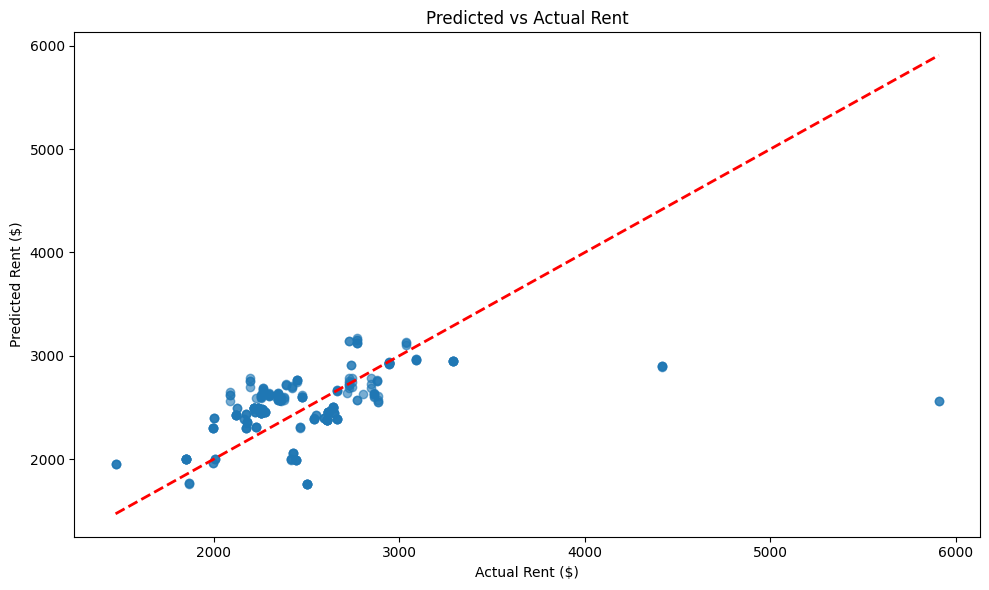

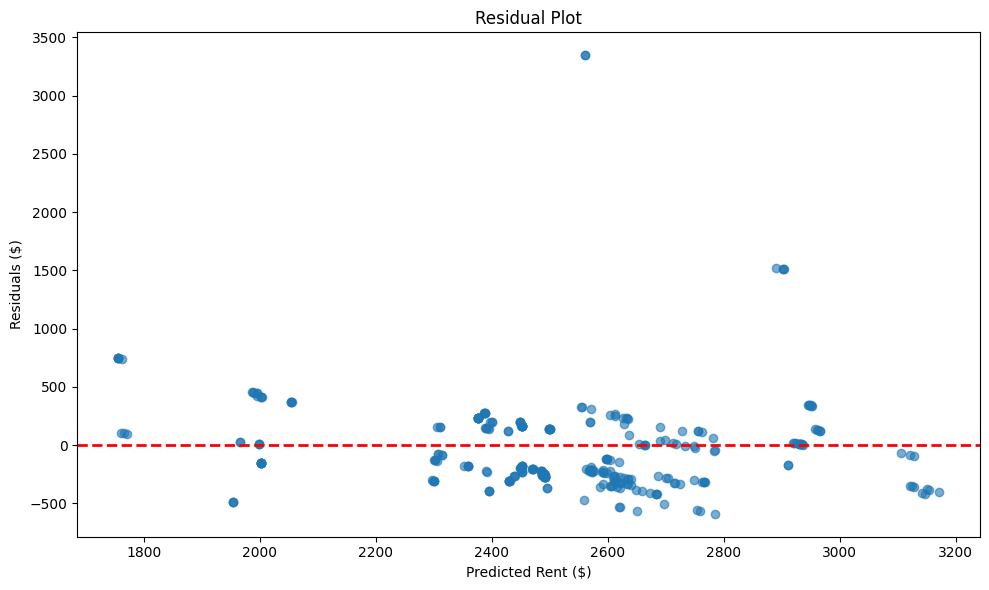

In [16]:
# Prediction vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rent ($)')
plt.ylabel('Predicted Rent ($)')
plt.title('Predicted vs Actual Rent')
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Rent ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

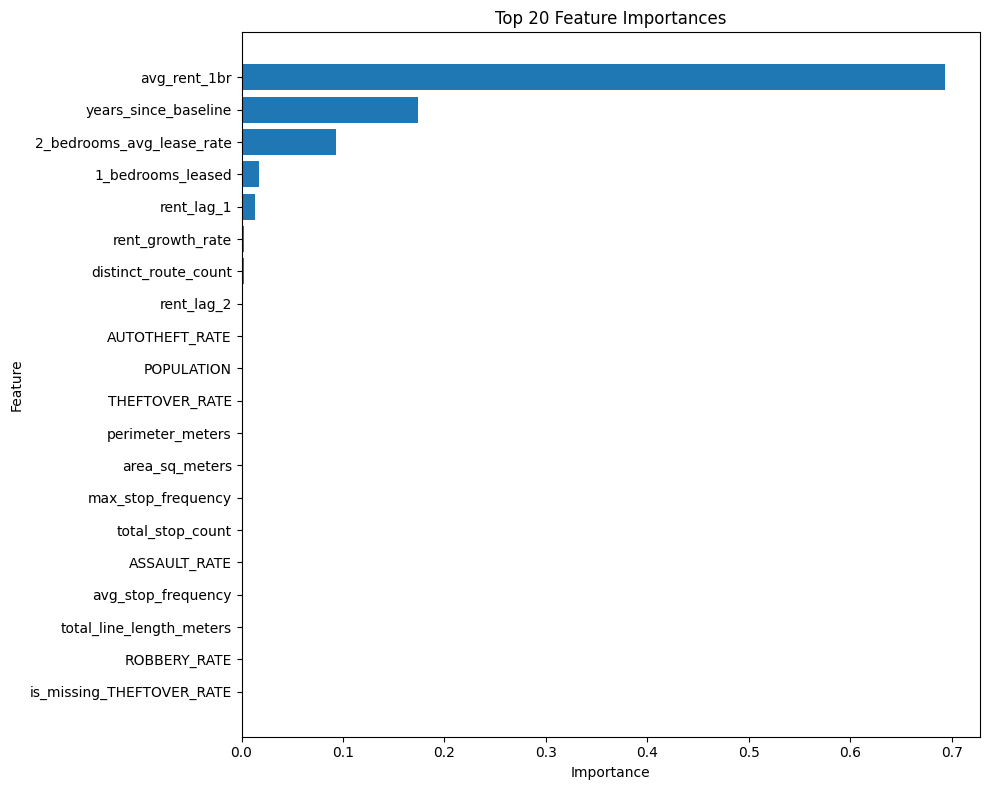


Top 10 Most Important Features:
                      feature  importance
16               avg_rent_1br    0.693060
23       years_since_baseline    0.173701
1   2_bedrooms_avg_lease_rate    0.093154
0           1_bedrooms_leased    0.017341
17                 rent_lag_1    0.013442
19           rent_growth_rate    0.002842
15       distinct_route_count    0.002049
18                 rent_lag_2    0.001497
6              AUTOTHEFT_RATE    0.000909
9                  POPULATION    0.000488


In [17]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Save the model for reference

In [18]:
# Save the trained model (optional)
import pickle

with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

print("Model saved as 'xgb_model_train_1.pkl'") # NOTE: make sure to change this per save, and document the changes.

Model saved as 'xgb_model_train_1.pkl'
